In [1]:
import pandas as pd
import numpy as np
import torch
import importlib
from utils.utils_dataset import prepare_k_fold_non_iid_dataset, plot_dataset_split, display_dataset_split
from sklearn import datasets
from sklearn.model_selection import KFold
from utils.utils_train import train_supervised, test_model
from utils.utils_plots import plot_first_feature_horizontal, save_figure
from utils.utils_metrics import calculate_metrics_statistics, calculate_cluster_stats, calculate_metrics, plot_confusion_matrix
import copy

In [2]:
from model.eGauss_plus import eGAUSSp

print("PyTorch Version:", torch.__version__)
print("CUDA Version:", torch.version.cuda)

# Check if CUDA is available
device = torch.device("cpu")
    

feature_dim = 4
num_classes = 3

# Model parameters
local_model_params = {
    "feature_dim": feature_dim,
    "num_classes": num_classes,
    "kappa_n": 1,
    "num_sigma": int(feature_dim),
    "kappa_join": 1.5,
    "S_0": 1e-8,
    "N_r": 4,
    "c_max": 1000,
    "device": device
}
federated_model_params = {
    "feature_dim": feature_dim,
    "num_classes": num_classes,
    "kappa_n": 1,
    "num_sigma": int(feature_dim),
    "kappa_join":  1.5,
    "S_0": 1e-8,
    "N_r": 4,
    "c_max": 1000,
    "device": device
}

PyTorch Version: 2.2.0
CUDA Version: 11.8


In [3]:
# Load the Iris dataset
iris = datasets.load_iris()

X = iris.data
y = iris.target

num_clients = 3
num_splits = 3
num_repetitions = 10

# Re-inserting the repetition of the experiment 10 times
experiment_results = []
for experiment in range(num_repetitions):
    kf = KFold(n_splits=num_splits, shuffle=True, random_state=None)

    # Initialize arrays to track samples per class for each client in each fold
    samples_per_class_per_client = np.zeros((num_clients, local_model_params["num_classes"], num_splits))

    # Main loop for k-fold cross-validation
    all_client_metrics = [[] for _ in range(num_clients)]
    all_client_clusters = [[] for _ in range(num_clients)]

    all_federated_metrics = []
    all_federated_clusters = []

    for i_fold, (train_index, test_index) in enumerate(kf.split(iris.data)):
        # Split the data
        train_data, test_data, all_data = prepare_k_fold_non_iid_dataset(X, y, train_index, test_index, num_clients)

        # Create the models
        local_models = [eGAUSSp(**local_model_params) for _ in range(num_clients)]
        federated_model = eGAUSSp(**federated_model_params)

        # Train and test the models
        for client_idx, client_model in enumerate(local_models):
            # Count the number of samples per class for this client in this fold
            for class_idx in range(client_model.num_classes):
                class_samples = torch.sum((train_data[client_idx][1] == class_idx).float(), dim=0)
                samples_per_class_per_client[client_idx, class_idx, i_fold] = class_samples

            # Supervised clustering
            train_supervised(client_model, train_data[client_idx])

            # Test the local models
            pred_scores, pred, _ = test_model(client_model, test_data)
            metrics = calculate_metrics(pred.cpu(), test_data, "weighted")
            all_client_metrics[client_idx].append(metrics)

            # Save the number of clusters
            num_client_clusters = torch.sum(client_model.n[:client_model.c] > 1).cpu()
            all_client_clusters[client_idx].append(num_client_clusters)

        # Aggregate local models
        for client_model in local_models:
            federated_model.federal_agent.merge_model_privately(client_model, federated_model.kappa_n, 0)
        
        aggregated_model = copy.deepcopy(federated_model)
        federated_model.federal_agent.federated_merging()
        federated_model.score = torch.ones_like(federated_model.score)
        federated_model.num_pred = torch.zeros_like(federated_model.num_pred)

        num_federated_clusters = torch.sum(federated_model.n[:federated_model.c] > 0).cpu()
        all_federated_clusters.append(num_federated_clusters)

        # Test the federated model
        _, pred_fed, _ = test_model(federated_model, test_data)
        federated_metrics = calculate_metrics(pred_fed.cpu(), test_data, "weighted")
        all_federated_metrics.append(federated_metrics)

    # Store results of each experiment
    experiment_results.append({
        "client_metrics": all_client_metrics,
        "client_clusters": all_client_clusters,
        "federated_metrics": all_federated_metrics,
        "federated_clusters": all_federated_clusters,
        "samples_per_class_per_client": samples_per_class_per_client
    })
    
# Displaying the result of the first experiment for brevity
experiment_results[0]  # Replace with desired processing or analysis of experiment results


Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.4937)
Updated var_glo values: tensor(0.7537)
Updated var_glo values: tensor(0.6684)
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.4074)
Updated var_glo values: tensor(0.6357)
Updated var_glo values: tensor(0.6021)
Evolving has been disabled.
Evolving has been enabled.


c:\Users\mihao\miniconda3\envs\eFedGauss\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mihao\miniconda3\envs\eFedGauss\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mihao\miniconda3\envs\eFedGauss\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.5090)
Updated var_glo values: tensor(0.8974)
Updated var_glo values: tensor(0.7677)
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.4603)
Updated var_glo values: tensor(0.7814)
Updated var_glo values: tensor(0.7026)
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\mihao\miniconda3\envs\eFedGauss\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mihao\miniconda3\envs\eFedGauss\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mihao\miniconda3\envs\eFedGauss\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

Evolving has been disabled.
Updated var_glo values: tensor(0.3806)
Updated var_glo values: tensor(0.5701)
Updated var_glo values: tensor(0.6308)
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.2613)
Updated var_glo values: tensor(0.7289)
Updated var_glo values: tensor(0.7049)
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\mihao\miniconda3\envs\eFedGauss\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mihao\miniconda3\envs\eFedGauss\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mihao\miniconda3\envs\eFedGauss\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

Evolving has been disabled.
Updated var_glo values: tensor(0.1991)
Updated var_glo values: tensor(0.7855)
Updated var_glo values: tensor(0.6656)
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.4395)
Updated var_glo values: tensor(0.8697)
Updated var_glo values: tensor(0.6884)
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.5896)
Updated var_glo values: tensor(0.7249)
Updated var_glo values: tensor(0.6799)
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\mihao\miniconda3\envs\eFedGauss\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mihao\miniconda3\envs\eFedGauss\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mihao\miniconda3\envs\eFedGauss\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.3979)
Updated var_glo values: tensor(0.7792)
Updated var_glo values: tensor(0.6152)
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.5924)
Updated var_glo values: tensor(0.8540)
Updated var_glo values: tensor(0.6945)
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\mihao\miniconda3\envs\eFedGauss\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mihao\miniconda3\envs\eFedGauss\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mihao\miniconda3\envs\eFedGauss\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

Evolving has been disabled.
Updated var_glo values: tensor(0.4553)
Updated var_glo values: tensor(0.8069)
Updated var_glo values: tensor(0.7089)
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.2042)
Updated var_glo values: tensor(0.5614)
Updated var_glo values: tensor(0.6062)
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.7350)
Updated var_glo values: tensor(0.7167)
Updated var_glo values: tensor(0.6987)
Evolving has been disabled.
Evolving has been enabled.


c:\Users\mihao\miniconda3\envs\eFedGauss\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mihao\miniconda3\envs\eFedGauss\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mihao\miniconda3\envs\eFedGauss\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.3132)
Updated var_glo values: tensor(0.6774)
Updated var_glo values: tensor(0.7372)
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.3047)
Updated var_glo values: tensor(0.7602)
Updated var_glo values: tensor(0.6559)
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.


c:\Users\mihao\miniconda3\envs\eFedGauss\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mihao\miniconda3\envs\eFedGauss\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mihao\miniconda3\envs\eFedGauss\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.4205)
Updated var_glo values: tensor(0.8539)
Updated var_glo values: tensor(0.7715)
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.3725)
Updated var_glo values: tensor(0.5892)
Updated var_glo values: tensor(0.6101)
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.3969)
Updated var_glo values: tensor(0.7731)
Updated var_glo values: tensor(0.6059)
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has be

c:\Users\mihao\miniconda3\envs\eFedGauss\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mihao\miniconda3\envs\eFedGauss\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mihao\miniconda3\envs\eFedGauss\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.3373)
Updated var_glo values: tensor(0.6691)
Updated var_glo values: tensor(0.6767)
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.4158)
Updated var_glo values: tensor(0.7474)
Updated var_glo values: tensor(0.6954)
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\mihao\miniconda3\envs\eFedGauss\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mihao\miniconda3\envs\eFedGauss\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mihao\miniconda3\envs\eFedGauss\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

Evolving has been disabled.
Updated var_glo values: tensor(0.4564)
Updated var_glo values: tensor(0.7321)
Updated var_glo values: tensor(0.6710)
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.3539)
Updated var_glo values: tensor(0.6686)
Updated var_glo values: tensor(0.6336)
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.3133)
Updated var_glo values: tensor(0.6695)
Updated var_glo values: tensor(0.6692)
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\mihao\miniconda3\envs\eFedGauss\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mihao\miniconda3\envs\eFedGauss\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mihao\miniconda3\envs\eFedGauss\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.3331)
Updated var_glo values: tensor(0.8569)
Updated var_glo values: tensor(0.7385)
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.3135)
Updated var_glo values: tensor(0.6639)
Updated var_glo values: tensor(0.5339)
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.3441)
Updated var_glo values: tensor(0.7891)
Updated var_glo values: tensor(0.7824)
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has be

c:\Users\mihao\miniconda3\envs\eFedGauss\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mihao\miniconda3\envs\eFedGauss\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mihao\miniconda3\envs\eFedGauss\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

{'client_metrics': [[{'accuracy': 0.56,
    'precision': 0.3957219251336898,
    'recall': 0.56,
    'f1_score': 0.44595520421607376},
   {'accuracy': 0.64,
    'precision': 0.4733333333333333,
    'recall': 0.64,
    'f1_score': 0.5358352402745995},
   {'accuracy': 0.62,
    'precision': 0.5405,
    'recall': 0.62,
    'f1_score': 0.5353341740226987}],
  [{'accuracy': 0.74,
    'precision': 0.596551724137931,
    'recall': 0.74,
    'f1_score': 0.6475555555555556},
   {'accuracy': 0.68,
    'precision': 0.5105882352941177,
    'recall': 0.68,
    'f1_score': 0.5692307692307692},
   {'accuracy': 0.58,
    'precision': 0.39837837837837836,
    'recall': 0.58,
    'f1_score': 0.45320754716981126}],
  [{'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0},
   {'accuracy': 0.66,
    'precision': 0.5054545454545455,
    'recall': 0.66,
    'f1_score': 0.56},
   {'accuracy': 0.98,
    'precision': 0.980909090909091,
    'recall': 0.98,
    'f1_score': 0.9799099774943736}]],
 'c

Evolving has been disabled.


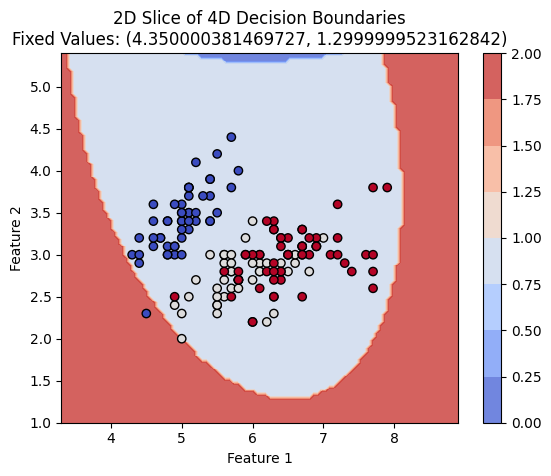

interactive(children=(FloatSlider(value=4.350000381469727, description='fixed_value3', max=6.900000095367432, …

<function __main__.visualize_decision_boundaries(fixed_value3, fixed_value4, num_points=100)>

In [4]:
 import numpy as np
import matplotlib.pyplot as plt
import torch

# Placeholder dataset and model loading
# Assuming 'test_data' is a tuple of (features_tensor, labels_tensor)
features_np = all_data[0].numpy()  # Convert features to NumPy array for manipulation
labels_np = all_data[1].numpy()    # Convert labels to NumPy array for plotting

def visualize_decision_boundaries(fixed_value3, fixed_value4, num_points=100):
    # Generate a meshgrid for the first and second dimensions
    x_min, x_max = features_np[:, 0].min() - 1, features_np[:, 0].max() + 1
    y_min, y_max = features_np[:, 1].min() - 1, features_np[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, num=num_points),
                         np.linspace(y_min, y_max, num=num_points))

    # Prepare the 4D input by combining meshgrid values with fixed values
    meshgrid_4d = np.c_[xx.ravel(), yy.ravel(),
                        np.full_like(xx.ravel(), fixed_value3),
                        np.full_like(yy.ravel(), fixed_value4)]

    # Convert the 4D meshgrid to a PyTorch tensor
    mesh_tensor = torch.tensor(meshgrid_4d, dtype=torch.float)

    # Assuming a function test_model for making predictions
    # Note: Adjust this to match how your model accepts and processes input
    pred_scores_mesh, pred_mesh, _ = test_model(federated_model, (mesh_tensor, None))

    # Reshape the predictions to the meshgrid shape for contour plot
    Z = pred_mesh.reshape(xx.shape)

    # Visualization
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)  # Z should be defined based on your model's prediction
    plt.colorbar()
    plt.scatter(features_np[:, 0], features_np[:, 1], c=labels_np, edgecolor='k', cmap=plt.cm.coolwarm)
    plt.title(f"2D Slice of 4D Decision Boundaries\nFixed Values: ({fixed_value3}, {fixed_value4})")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

# Example usage
visualize_decision_boundaries(fixed_value3=np.median(features_np[:, 2]), fixed_value4=np.median(features_np[:, 3]))

from ipywidgets import interact, FloatSlider, fixed

# Define the range of sliders based on your data or desired exploration range
interact(visualize_decision_boundaries,
         fixed_value3=FloatSlider(value=np.median(features_np[:, 2]), min=features_np[:, 2].min() , max=features_np[:,2].max() , step=0.1),
         fixed_value4=FloatSlider(value=np.median(features_np[:, 3]), min=features_np[:, 3].min() , max=features_np[:, 3].max() , step=0.1),
         num_points=fixed(100))

Evolving has been disabled.
Evolving has been disabled.


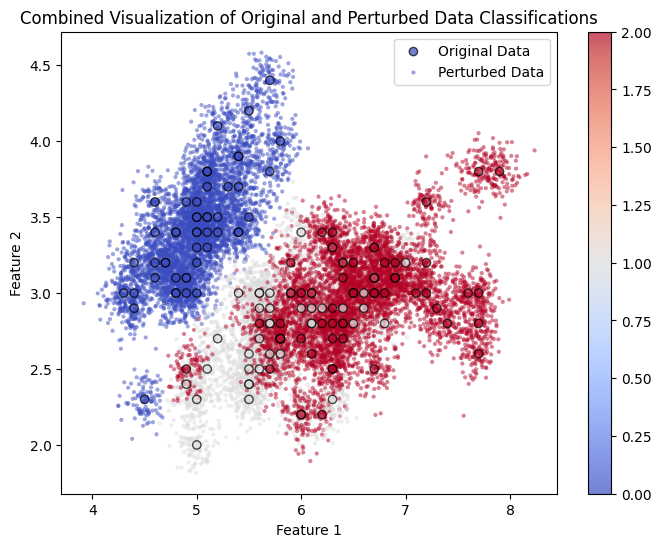

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def add_perturbation(features, std_dev=1, num_samples=100):
    """
    Add Gaussian noise to the original features to generate perturbed data points.
    
    Parameters:
    - features: Original features as a numpy array.
    - std_dev: Standard deviation of the Gaussian noise.
    - num_samples: Number of perturbed samples to generate per original data point.
    
    Returns:
    - perturbed_features: Numpy array containing the perturbed features.
    """
    # Expand the features array to include the number of samples per point
    expanded_features = np.repeat(features, num_samples, axis=0)
    
    # Generate Gaussian noise
    noise = np.random.normal(loc=0.0, scale=std_dev, size=expanded_features.shape)
    
    # Add noise to original features to create perturbed samples
    perturbed_features = expanded_features + noise
    return perturbed_features

def visualize_combined_classification_and_perturbation(model, all_data, std_dev=1, num_samples=100):
    """
    Visualize the classifications of original and perturbed data on the same plot.
    
    Parameters:
    - model: The trained model for making predictions.
    - all_data: Tuple of (features_tensor, labels_tensor) representing the dataset.
    - std_dev: Standard deviation for the perturbations added to the data.
    """
    features_np, labels_np = all_data
    features_np = features_np.numpy()  # Assuming features are in a tensor
    labels_np = labels_np.numpy()      # Assuming labels are in a tensor
    
    # Generate 100x more perturbed data
    perturbed_features_np = add_perturbation(features_np, std_dev=std_dev, num_samples=num_samples)

    # Convert to tensors for model prediction
    features_tensor = torch.tensor(features_np, dtype=torch.float)
    perturbed_features_tensor = torch.tensor(perturbed_features_np, dtype=torch.float)

    # Convert to tensors for model prediction
    features_tensor = torch.tensor(features_np, dtype=torch.float)
    perturbed_features_tensor = torch.tensor(perturbed_features_np, dtype=torch.float)

    # Assuming 'test_model' returns predictions as the second item in a tuple
    _, original_preds,_ = test_model(model, (features_tensor, None))
    _, perturbed_preds,_ = test_model(model, (perturbed_features_tensor, None))

    # Visualization on the same plot
    plt.figure(figsize=(8, 6))
        # Overlay perturbed data points with their classifications
    scatter_perturbed = plt.scatter(perturbed_features_np[:, 0], perturbed_features_np[:, 1], c=perturbed_preds, 
                                    edgecolor='none', alpha=0.5, cmap=plt.cm.coolwarm, marker='.', label='Perturbed Data')

    # Plot original data points with their classifications
    scatter_original = plt.scatter(features_np[:, 0], features_np[:, 1], c=original_preds, 
                                    edgecolor='k', alpha=0.7, cmap=plt.cm.coolwarm, marker='o', label='Original Data')
    

    plt.title("Combined Visualization of Original and Perturbed Data Classifications")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend(handles=[scatter_original, scatter_perturbed], loc='best')
    plt.colorbar()
    plt.show()

# Assuming 'add_perturbation' is defined as before
# Assuming 'client_model' is your trained model and 'all_data' is your dataset

visualize_combined_classification_and_perturbation(aggregated_model, all_data, std_dev=0.1)


Evolving has been disabled.


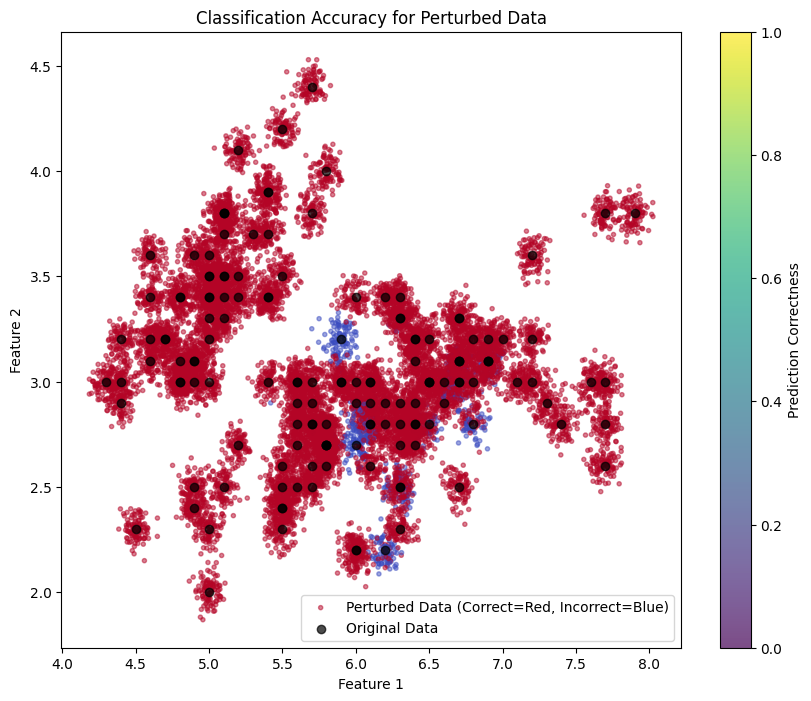

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def visualize_classification_accuracy(model, all_data, std_dev=0.05, num_samples=100):
    features_np, labels_np = all_data
    features_np = features_np.numpy()  # Convert features to NumPy array
    labels_np = labels_np.numpy()      # Convert labels to NumPy array
    
    # Generate perturbed data
    perturbed_features_np = add_perturbation(features_np, std_dev=std_dev, num_samples=num_samples)

    # Convert perturbed data to PyTorch tensor for model prediction
    perturbed_features_tensor = torch.tensor(perturbed_features_np, dtype=torch.float)

    # Predict classifications for the perturbed data
    _, perturbed_preds,_ = test_model(model, (perturbed_features_tensor, None))

    # Ensure perturbed_preds is a numpy array for comparison
    if isinstance(perturbed_preds, torch.Tensor):
        perturbed_preds = perturbed_preds.numpy()
    
    # Repeat the labels to match the perturbed data size
    repeated_labels = np.repeat(labels_np, num_samples)
    
    # Compare predictions with true labels to determine correctness
    accuracy_mask = np.equal(perturbed_preds, repeated_labels).astype(int)

    # Visualization
    plt.figure(figsize=(10, 8))
    
    # Perturbed data points colored by correctness
    plt.scatter(perturbed_features_np[:, 0], perturbed_features_np[:, 1], c=accuracy_mask, 
                alpha=0.5, cmap=plt.cm.coolwarm, marker='.', label='Perturbed Data (Correct=Red, Incorrect=Blue)')
    
    # Original data points
    plt.scatter(features_np[:, 0], features_np[:, 1], c='black', edgecolor='k', alpha=0.7, label='Original Data')
    

    plt.title("Classification Accuracy for Perturbed Data")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.colorbar(label='Prediction Correctness')
    plt.show()

# Ensure 'client_model', 'test_model', and 'all_data' are correctly defined and accessible
visualize_classification_accuracy(aggregated_model, all_data, std_dev=0.05, num_samples=100)


In [7]:
import numpy as np

# Initialize variables to store aggregated data
agg_client_metrics = [{} for _ in range(num_clients)]
agg_federated_metrics = {}
agg_client_clusters = [[] for _ in range(num_clients)]
agg_federated_clusters = []

# Process each experiment
for result in experiment_results:
    for client_idx, client_metrics in enumerate(result['client_metrics']):
        for metric in client_metrics[0].keys():
            if metric not in agg_client_metrics[client_idx]:
                agg_client_metrics[client_idx][metric] = []
            agg_client_metrics[client_idx][metric].extend([m[metric] for m in client_metrics])

    for metric in result['federated_metrics'][0].keys():
        if metric not in agg_federated_metrics:
            agg_federated_metrics[metric] = []
        agg_federated_metrics[metric].extend([m[metric] for m in result['federated_metrics']])

    for client_idx, client_clusters in enumerate(result['client_clusters']):
        agg_client_clusters[client_idx].extend(client_clusters)

    agg_federated_clusters.extend(result['federated_clusters'])

# Calculate averages and standard deviations
for client_metrics in agg_client_metrics:
    for metric, values in client_metrics.items():
        mean = np.mean(values)
        std = np.std(values, ddof=1)
        client_metrics[metric] = (mean, std)

for metric, values in agg_federated_metrics.items():
    mean = np.mean(values)
    std = np.std(values, ddof=1)
    agg_federated_metrics[metric] = (mean, std)

# Example of printing aggregated metrics for the first client
print("Aggregated Metrics for Client 1:")
for metric, (mean, std) in agg_client_metrics[0].items():
    print(f"{metric}: {mean:.2f} ± {std:.2f}")

agg_samples = np.zeros((num_clients, num_classes, num_splits))

# Aggregate data from each experiment
for result in experiment_results:
    samples_per_class_per_client = result['samples_per_class_per_client']
    agg_samples += samples_per_class_per_client

# Compute the average across all repetitions (and folds if required)
avg_samples = agg_samples / len(experiment_results)

# Calculate the average for each client and class across folds
avg_samples_per_class_per_client = avg_samples.mean(axis=2)

# Print the results
for client_idx in range(num_clients):
    print(f"Client {client_idx + 1}:")
    for class_idx in range(num_classes):
        avg_samples = avg_samples_per_class_per_client[client_idx, class_idx]
        print(f"  Class {class_idx}: {avg_samples:.2f} samples")

Aggregated Metrics for Client 1:
accuracy: 0.60 ± 0.06
precision: 0.46 ± 0.07
recall: 0.60 ± 0.06
f1_score: 0.50 ± 0.06
Client 1:
  Class 0: 0.00 samples
  Class 1: 11.87 samples
  Class 2: 10.70 samples
Client 2:
  Class 0: 22.40 samples
  Class 1: 0.00 samples
  Class 2: 11.47 samples
Client 3:
  Class 0: 10.93 samples
  Class 1: 21.47 samples
  Class 2: 11.17 samples


In [8]:
# Create a LaTeX table for the paper
# Start the LaTeX table code
latex_table = r"""\begin{table}[ht]
\centering
\setlength{\tabcolsep}{2pt}
\scriptsize
\caption{Performance metrics and average number of clusters on the Iris dataset.}
\label{tab:performance_clusters}
\begin{tabular}{lcccccc}
\toprule
\textbf{Metric} & \textbf{Client 1} & \textbf{Client 2} & \textbf{Client 3} & \textbf{Client 4} & \textbf{Federated} \\
"""

# Add the header for average samples per class
latex_table += r"Average Samples"

# Add the average samples per class for each client
samples_row = ""
for samples in avg_samples_per_class_per_client:
    samples_row += " & " + "/".join([f"{x:.1f}" for x in samples])
latex_table += samples_row + " \\\\" + "\n"

latex_table += r"\midrule" + "\n"


# Add rows for each metric
metrics = ['accuracy', 'precision', 'recall', 'f1_score']
metric_names = ['Accuracy (\%)', 'Precision (\%)', 'Recall (\%)', 'F1 Score (\%)']
for i, metric in enumerate(metrics):
    row = metric_names[i] + r' $\uparrow$'
    for client_metrics in agg_client_metrics:
        mean, std = client_metrics[metric]
        row += f' & {mean * 100:.1f} ± {std * 100:.1f}'
    mean, std = agg_federated_metrics[metric]
    row += r' & \bf' + f'{{{mean * 100:.1f} ± {std * 100:.1f}}}'
    latex_table += row + r' \\' + '\n'

# Add row for clusters
cluster_row = r'\#Clusters $\downarrow$'
for client_clusters in agg_client_clusters:
    avg_clusters = np.mean(client_clusters)
    std_clusters = np.std(client_clusters, ddof=1)
    cluster_row += f' & {avg_clusters:.1f} ± {std_clusters:.1f}'

# Assuming agg_federated_clusters is a list of cluster counts for the federated model
avg_fed_clusters = np.mean(agg_federated_clusters)
std_fed_clusters = np.std(agg_federated_clusters, ddof=1)
cluster_row += r' & \bf' + f'{{{avg_fed_clusters:.1f} ± {std_fed_clusters:.1f}}}'

latex_table += cluster_row + r' \\' + '\n'

# End the LaTeX table code
latex_table += r"""\bottomrule
\end{tabular}
\end{table}
"""

# Print the complete LaTeX table
print(latex_table)


\begin{table}[ht]
\centering
\setlength{\tabcolsep}{2pt}
\scriptsize
\caption{Performance metrics and average number of clusters on the Iris dataset.}
\label{tab:performance_clusters}
\begin{tabular}{lcccccc}
\toprule
\textbf{Metric} & \textbf{Client 1} & \textbf{Client 2} & \textbf{Client 3} & \textbf{Client 4} & \textbf{Federated} \\
Average Samples & 0.0/11.9/10.7 & 22.4/0.0/11.5 & 10.9/21.5/11.2 \\
\midrule
Accuracy (\%) $\uparrow$ & 59.7 ± 6.1 & 66.7 ± 7.0 & 93.7 ± 6.6 & \bf{96.2 ± 1.8} \\
Precision (\%) $\uparrow$ & 45.8 ± 7.0 & 50.2 ± 8.1 & 94.0 ± 8.7 & \bf{96.6 ± 1.6} \\
Recall (\%) $\uparrow$ & 59.7 ± 6.1 & 66.7 ± 7.0 & 93.7 ± 6.6 & \bf{96.2 ± 1.8} \\
F1 Score (\%) $\uparrow$ & 49.8 ± 6.2 & 55.7 ± 8.3 & 93.3 ± 8.3 & \bf{96.2 ± 1.9} \\
\#Clusters $\downarrow$ & 4.0 ± 1.2 & 2.3 ± 0.5 & 3.1 ± 0.3 & \bf{3.0 ± 0.2} \\
\bottomrule
\end{tabular}
\end{table}



Client 1: {1: 13, 2: 11}
Client 2: {0: 24, 2: 11}
Client 3: {0: 13, 1: 16, 2: 12}
Test Set: {0: 13, 1: 21, 2: 16}

Combined Number of Samples per Class:
Class 0: 50 samples
Class 1: 50 samples
Class 2: 50 samples

Total Number of Samples Across All Datasets: 150
Figure saved as .Images/iris_data_distribution.svg in svg format.


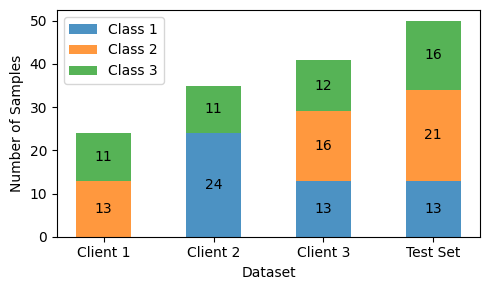

In [9]:
#Aditional plots of the data
display_dataset_split(train_data, test_data)
fig = plot_dataset_split(train_data, test_data)
save_figure(fig, ".Images/iris_data_distribution.svg","svg")

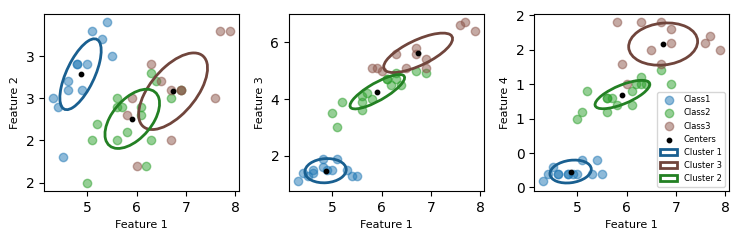

Figure saved as .Images/iris_local_model.svg in svg format.
Figure saved as .Images/iris_local_model.pdf in pdf format.


In [10]:
#Plot of the last local model
fig = plot_first_feature_horizontal(train_data[client_idx], model=client_model, num_sigma=2, N_max=1, title="",format='%d', legend = True, data_name = "Class")  
save_figure(fig, ".Images/iris_local_model.svg", "svg")
save_figure(fig, ".Images/iris_local_model.pdf","pdf")

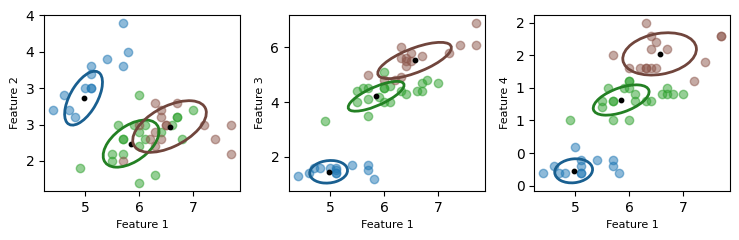

Number of clusters after merging = 3
Figure saved as .Images/iris_federated_merged.svg in svg format.
Figure saved as .Images/iris_federated_merged.pdf in pdf format.


In [11]:
#Plot of the last federated model
fig = plot_first_feature_horizontal(test_data, model=federated_model.cpu(), num_sigma=2, N_max=0, title="", format='%d')   
print(f"Number of clusters after merging = {federated_model.c}")
save_figure(fig, ".Images/iris_federated_merged.svg","svg")
save_figure(fig, ".Images/iris_federated_merged.pdf","pdf")

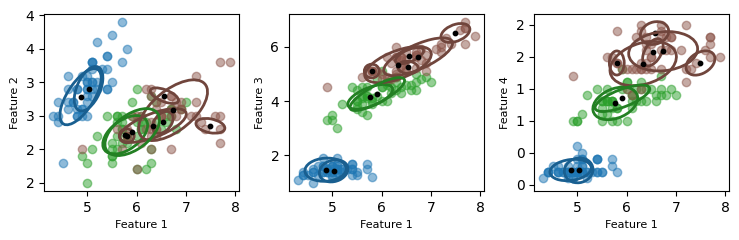

Figure saved as .Images/iris_aggregated.svg in svg format.
Figure saved as .Images/iris_aggregated.pdf in pdf format.


In [12]:
#Plot of the last aggregated model
fig = plot_first_feature_horizontal(all_data, model= aggregated_model.cpu(), num_sigma=2, N_max=0, title="", format='%d')   
save_figure(fig, ".Images/iris_aggregated.svg","svg")
save_figure(fig, ".Images/iris_aggregated.pdf","pdf")

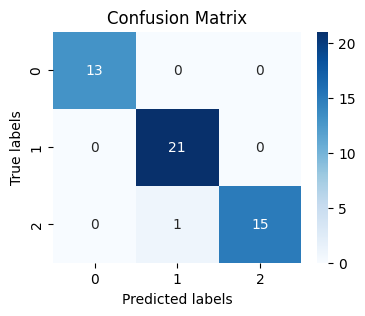

In [13]:
plot_confusion_matrix(pred_fed.cpu(), test_data)